In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

import recursive as sv
import pickle
from os import path

In [2]:
data_path = path.join(*(['..']*3+['data','time_series_linear_interpolations']))
path.exists(data_path)

True

In [3]:
with open(path.join(data_path,'olap2.pickle'),'rb') as a:
    svdata = pickle.load(a)

In [4]:
list(svdata.sessions._data[1]._data[1]._data.keys())

['session', 'hr', 'drumming']

In [5]:
svdata.group_id[7]

1009

In [6]:
def get_group_id(svdata, gr_ind):
    return svdata.group_id[gr_ind]

def get_drumming_by_group(svdata,gr_ind):
    sample_drumming=sv.list_store(svdata.sessions.sample(3)).drumming[gr_ind].signal_4hz
    drumming_arr = np.array(sample_drumming.tolist())
    x = drumming_arr[0,0,:]
    y = drumming_arr[:,1,:]
    return x,y

In [7]:
def active_index_range(v1, v2,tol=0.02):
    # find the active time range
    l = v1.size
    start,stop = 0,l
    thres = np.finfo(float).eps #2.220446049250313e-16
    while True:
        w = np.vstack([v1[start:stop],v2[start:stop]])
        m = w.mean()
        new_thres = 0.2*m
        if (new_thres-thres)/thres < tol:
            break
        thres=new_thres
        both_active = (w[0,:]>thres) & (w[1,:]>thres)
        active_ind = np.arange(start,stop)[both_active]
        start = active_ind.min()
        stop = active_ind.max()
    return start, stop, thres

In [8]:
swish = lambda b: lambda x:  x * expit(x-b)
dist = lambda a: lambda x: a*x**2
damp = lambda k: lambda x: 2*expit(k*x)-1


In [9]:
score_func = lambda x: 1-damp(20)(swish(4)(dist(20)(x*2)))

In [10]:
def score_drumming_signals(v1, v2, local=True):
    start, stop, _ = active_index_range(v1,v2)
    width = stop-start
    if width < 200: # 50 seconds
        raise ValueError("Cannot find active range. Found {} {}".format(start, stop))
    s = np.nan*np.ones_like(v1)
    s[start:stop] = score_func((v1-v2)[start:stop])
    if local:
        return s
    return np.nansum(s)/width

def score_drumming_triplets(v, local=True):
    return score_drumming_signals(v.min(axis=0), v.max(axis=0),local)

def mean_score_triplet(v):
    return score_drumming_triplet(v, False)

In [11]:
x, y = get_drumming_by_group(svdata,8)
    

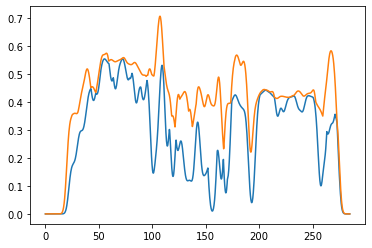

In [12]:
plt.plot(x,y.min(axis=0).T)
plt.plot(x,y.max(axis=0).T)

In [13]:
y.shape

(3, 1140)

In [15]:
score_drumming_triplets(y.T,False)

ValueError: zero-size array to reduction operation minimum which has no identity